In [1]:
import pandas
import numpy
from matplotlib import pyplot
%matplotlib inline

### IO: Reading and preprocess the data

We can define a function which will read the data and process them.

In [2]:
def read_spectra(path_csv):
    """Read and parse data in pandas DataFrames.
    
    Parameters
    ----------
    path_csv : str
        Path to the CSV file to read.
        
    Returns
    -------
    s : pandas DataFrame, shape (n_spectra, n_freq_point)
        DataFrame containing all Raman spectra.
        
    c : pandas Series, shape (n_spectra,)
        Series containing the concentration of the molecule.
        
    m : pandas Series, shape (n_spectra,)
        Series containing the type of chemotherapeutic agent.
        
    """
    s = pandas.read_csv(path_csv)
    c = s['concentration']
    m = s['molecule']
    s = s['spectra']
    x = []
    for spec in s:
        x.append(numpy.fromstring(spec[1:-1], sep=','))
    s = pandas.DataFrame(x)
    
    return s, c, m

In [3]:
# read the frequency and get a pandas serie
f = pandas.read_csv('data/freq.csv')['freqs']

# read all data for training
filenames = ['data/spectra_{}.csv'.format(i)
             for i in range(4)]

stot = []
c = []
m = []
for filename in filenames:
    s_tmp, c_tmp, m_tmp = read_spectra(filename)
    stot.append(s_tmp)
    c.append(c_tmp)
    m.append(m_tmp)

stot = pandas.concat(stot)
c = pandas.concat(c)
m = pandas.concat(m)

### Plot helper functions

We can create two functions: (i) to plot all spectra and (ii) plot the mean spectra with the std intervals.
We will make a "private" function which will be used by both plot types.

In [4]:
def _apply_axis_layout(ax, title):
    """Apply despine style and add labels to axis."""
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Concentration')
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

def plot_spectra(f, s, title):
    """Plot a bunch of Raman spectra.
    
    Parameters
    ----------
    f : pandas Series, shape (n_freq_points,)
        Frequencies for which the Raman spectra were acquired.
        
    s : pandas DataFrame, shape (n_spectra, n_freq_points)
        DataFrame containing all Raman spectra.
        
    title : str
        Title added to the plot.
    
    Returns
    -------
    None
    
    """
    fig, ax = pyplot.subplots()
    ax.plot(f, s.T)
    _apply_axis_layout(ax, title)
    
def plot_spectra_by_type(f, s, classes, title):
    """Plot mean spectrum with its variance for a given class.
    
    Parameters
    ----------
    f : pandas Series, shape (n_freq_points,)
        Frequencies for which the Raman spectra were acquired.
        
    s : pandas DataFrame, shape (n_spectra, n_freq_points)
        DataFrame containing all Raman spectra.
        
    classes : array-like, shape (n_classes,)
        Array contining the different spectra class which will be plotted.
        
    title : str
        Title added to the plot.
        
    Returns
    -------
    None
    
    """
    fig, ax = pyplot.subplots()
    for c_type in numpy.unique(classes):
        i = numpy.nonzero(classes == c_type)[0]
        ax.plot(f, numpy.mean(s.iloc[i], axis=0), label=c_type)
        ax.fill_between(f, numpy.mean(s.iloc[i], axis=0) + numpy.std(s.iloc[i], axis=0), numpy.mean(s.iloc[i], axis=0) - numpy.std(s.iloc[i], axis=0), alpha=0.2)
    _apply_axis_layout(ax, title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

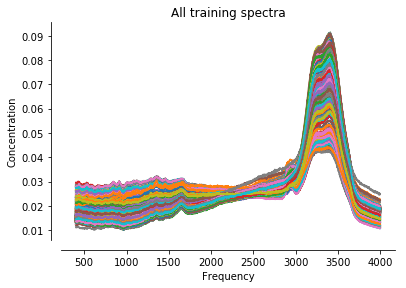

In [5]:
plot_spectra(f, stot, 'All training spectra')

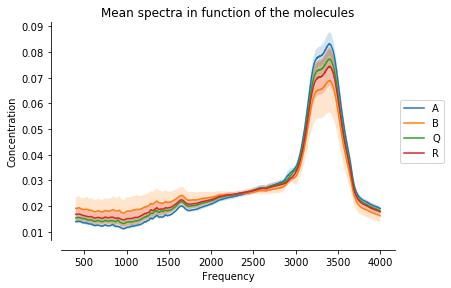

In [6]:
plot_spectra_by_type(f, stot, m, 'Mean spectra in function of the molecules')

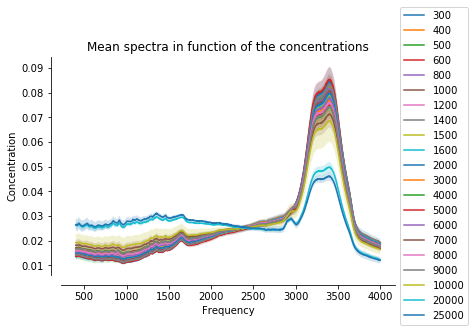

In [7]:
plot_spectra_by_type(f, stot, c, 'Mean spectra in function of the concentrations')

### Reusability for new data:

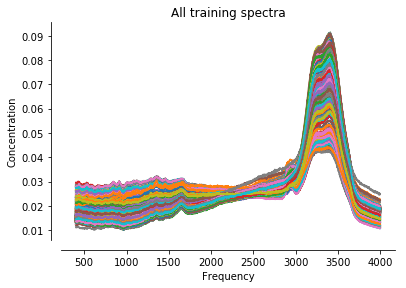

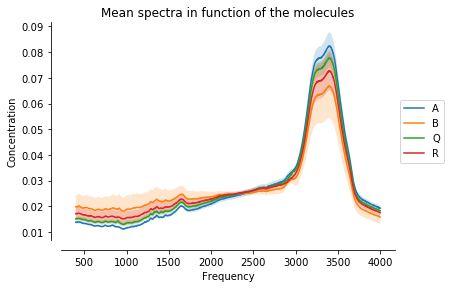

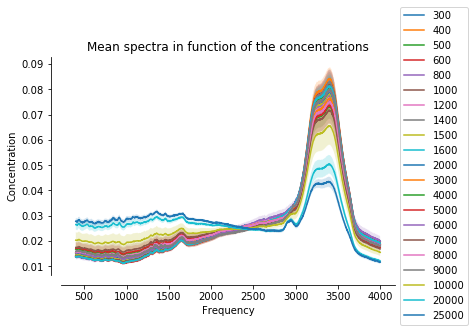

In [8]:
s4, c4, m4 = read_spectra('data/spectra_4.csv')

plot_spectra(f, stot, 'All training spectra')
plot_spectra_by_type(f, s4, m4, 'Mean spectra in function of the molecules')
plot_spectra_by_type(f, s4, c4, 'Mean spectra in function of the concentrations')

## Training and testing a machine learning model for classification

In [9]:
def plot_cm(cm, classes, title):
    """Plot a confusion matrix.
    
    Parameters
    ----------
    cm : ndarray, shape (n_classes, n_classes)
        Confusion matrix.
        
    classes : array-like, shape (n_classes,)
        Array contining the different spectra classes used in the
        classification problem.
        
    title : str
        Title added to the plot.
        
    Returns
    -------
    None
    
    """
    import itertools
    fig, ax = pyplot.subplots()
    pyplot.imshow(cm, interpolation='nearest', cmap='bwr')
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = numpy.arange(len(numpy.unique(classes)))
    pyplot.xticks(tick_marks, numpy.unique(classes), rotation=45)
    pyplot.yticks(tick_marks, numpy.unique(classes))

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')

Accuracy score: 0.83
Accuracy score: 0.93


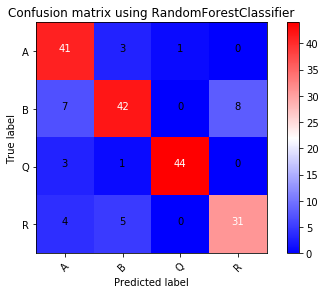

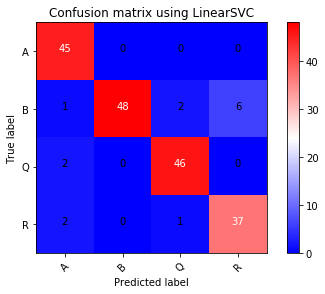

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

for clf in [RandomForestClassifier(random_state=0),
            LinearSVC(random_state=0)]:
    p = make_pipeline(StandardScaler(), PCA(n_components=100, random_state=0), clf)
    p.fit(stot, m)
    pred = p.predict(s4)
    plot_cm(confusion_matrix(m4, pred), p.classes_, 'Confusion matrix using {}'.format(clf.__class__.__name__))
    print('Accuracy score: {0:.2f}'.format(p.score(s4, m4)))

## Training and testing a machine learning model for regression

In [11]:
def plot_regression(y_true, y_pred, title):
    """Plot actual vs. predicted scatter plot.
    
    Parameters
    ----------
    y_true : array-like, shape (n_samples,)
        Ground truth (correct) target values.

    y_pred : array-like, shape (n_samples,)
        Estimated targets as returned by a regressor.

    title : str
        Title added to the plot.
    
    Returns
    -------
    None
    
    """
    from sklearn.metrics import r2_score, median_absolute_error
    fig, ax = pyplot.subplots()
    ax.scatter(y_true, y_pred)
    ax.plot([0, 25000], [0, 25000], '--k')
    ax.set_ylabel('Target predicted')
    ax.set_xlabel('True Target')
    ax.set_title(title)
    ax.text(1000, 20000, r'$R^2$=%.2f, MAE=%.2f' % (
       r2_score(y_true, y_pred), median_absolute_error(y_true, y_pred)))
    ax.set_xlim([0, 25000])
    ax.set_ylim([0, 25000])

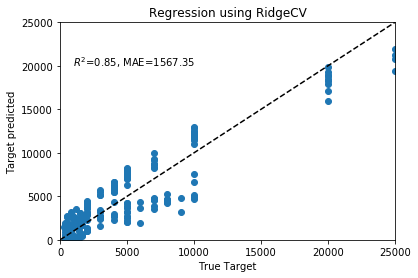

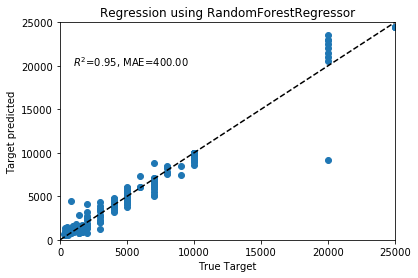

In [12]:
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

for reg in [RidgeCV(), RandomForestRegressor(random_state=0)]:
    p = make_pipeline(PCA(n_components=100), reg)
    p.fit(stot, c)
    pred = p.predict(s4)
    plot_regression(c4, pred, 'Regression using {}'.format(reg.__class__.__name__))

In [13]:
def fit_params(data):
    """Compute statistics for robustly scale data.
    
    Compute the median and the variance, i.e. the difference
    between the 75th and 25th percentiles.
    These statistics are used later to scale data.
    
    Parameters
    ----------
    data : pandas DataFrame, shape (n_spectra, n_freq_point)
        DataFrame containing all Raman spectra.
        
    Returns
    -------
    median : ndarray, shape (n_freq_point,)
        Median for each wavelength.
        
    variance : ndarray, shape (n_freq_point,)
        Variance (difference between the 75th and 25th
        percentiles) for each wavelength.
    
    """
    median = numpy.median(data, axis=0)
    p_25 = numpy.percentile(data, 25, axis=0)
    p_75 = numpy.percentile(data, 75, axis=0)
    return median, (p_75 - p_25)

def transform(data, median, var_25_75):
    """Scale data using robust estimators.
    
    Scale the data by subtracting the median and dividing by the
    variance, i.e. the difference between the 75th and 25th percentiles.
    
    Parameters
    ----------
    data : pandas DataFrame, shape (n_spectra, n_freq_point)
        DataFrame containing all Raman spectra.
        
    median : ndarray, shape (n_freq_point,)
        Median for each wavelength.
        
    var_25_75 : ndarray, shape (n_freq_point,)
        Variance (difference between the 75th and 25th
        percentiles) for each wavelength.
    
    Returns
    -------
    data_scaled : pandas DataFrame, shape (n_spectra, n_freq_point)
        DataFrame containing all scaled Raman spectra.
    
    """
    return (data - median) / var_25_75

In [14]:
median, var_25_75 = fit_params(stot)
stot_scaled = transform(stot, median, var_25_75)
s4_scaled = transform(s4, median, var_25_75)

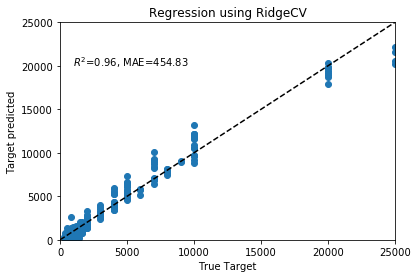

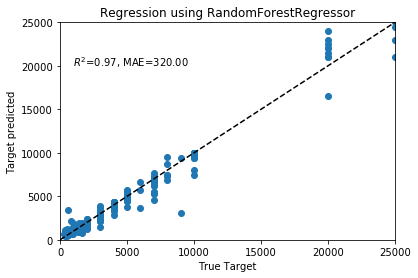

In [15]:
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

for reg in [RidgeCV(), RandomForestRegressor(random_state=0)]:
    p = make_pipeline(PCA(n_components=100), reg)
    p.fit(stot_scaled, c)
    pred = p.predict(s4_scaled)
    plot_regression(c4, pred, 'Regression using {}'.format(reg.__class__.__name__))